### My Model <hr>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil

import torch
import torch.nn as nn           
import torch.nn.functional as F 
import torch.optim as optim
import torchmetrics.functional as metrics
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchviz import make_dot

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


c:\ProgramData\anaconda3\envs\Torch_PY38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
tdata_path = './DATA/wikiart_csv/artist_train.csv'
vdata_path = './DATA/wikiart_csv/artist_valid.csv'

In [3]:
train_infoDF = pd.read_csv(tdata_path, header = None)
valid_infoDF = pd.read_csv(vdata_path, header = None)

In [4]:
train_infoDF = pd.concat([train_infoDF[0].str.split('/', expand = True), train_infoDF[1]], axis = 1)
train_infoDF.columns = ['style', 'file name', 'class']
valid_infoDF = pd.concat([valid_infoDF[0].str.split('/', expand = True), valid_infoDF[1]], axis = 1)
valid_infoDF.columns = ['style', 'file name', 'class']

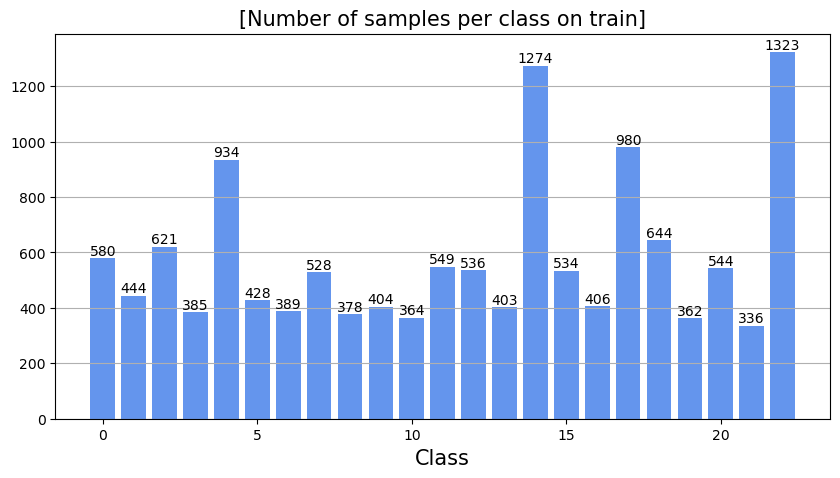

In [5]:
plt.figure(figsize = (10, 5))
plt.bar(train_infoDF['class'].value_counts().index, train_infoDF['class'].value_counts().values, color = 'cornflowerblue')
plt.title('[Number of samples per class on train]', size = 15)
plt.xlabel('Class', size = 15)
plt.grid(axis ='y')
y = train_infoDF['class'].value_counts(sort = False).values
for i, v in enumerate(dict(train_infoDF['class'].value_counts(sort = False))):
         plt.text(v, y[i], y[i], fontsize = 10, color='black', horizontalalignment='center', verticalalignment='bottom')
plt.show()

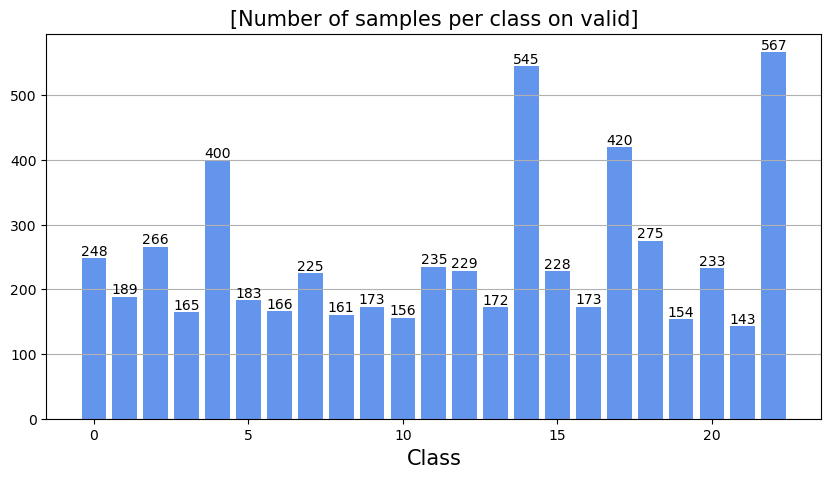

In [6]:
plt.figure(figsize = (10, 5))
plt.bar(valid_infoDF['class'].value_counts().index, valid_infoDF['class'].value_counts().values, color = 'cornflowerblue')
plt.title('[Number of samples per class on valid]', size = 15)
plt.xlabel('Class', size = 15)
plt.grid(axis = 'y')
y = valid_infoDF['class'].value_counts(sort = False).values
for i, v in enumerate(dict(valid_infoDF['class'].value_counts(sort = False))):
         plt.text(v, y[i], y[i], fontsize = 10, color='black', horizontalalignment='center', verticalalignment='bottom')
plt.show()

In [7]:
# Resnet 전처리
preprocessing = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])

In [8]:
train_root = './DATA/train/'
valid_root = './DATA/valid/'
trainDS = ImageFolder(root = train_root,
            transform = preprocessing)
validDS = ImageFolder(root = valid_root,
            transform = preprocessing)

In [9]:
print(f'Number of sample in trainDS => {len(trainDS)}\n\nNumber of sample in validDS => {len(validDS)}')

Number of sample in trainDS => 13346

Number of sample in validDS => 5706


In [10]:
trainDS[0][0].shape

torch.Size([3, 64, 64])

In [11]:
# print(f'TrainDS => {trainDS.classes}, {trainDS.targets}, {trainDS.imgs}', sep = '\n')
# print(f'ValidDS => {validDS.classes}, {validDS.targets}, {validDS.imgs}', sep = '\n')

In [12]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.0  Device: cpu


In [13]:
BATCH_SIZE = 64

In [14]:
trainDL = DataLoader(trainDS, batch_size = BATCH_SIZE, num_workers = 8, shuffle = True, drop_last = True)
#for (img, label) in trainDL: print(img.shape, label)

In [15]:
validDL = DataLoader(validDS, batch_size = BATCH_SIZE, num_workers = 8, shuffle = False, drop_last = True)
#for (img, label) in validDL: print(img.shape, label)

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 32),
            nn.ReLU(),
            nn.Dropout(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 16),
            nn.ReLU(),
            nn.Dropout(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = 8),
            nn.ReLU(),
            nn.Dropout(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer4 = nn.Sequential(
            nn.Linear(8 * 8 * 8, 64),
            nn.BatchNorm1d(num_features = 64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(num_features = 32),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(32, 23))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(-1, 8 * 8 * 8)
        x = self.layer4(x)
        return x

In [17]:
### ===> Optimizer, Objective Function 설정
my_model = CNN().to(DEVICE)

OPTIMIZER = torch.optim.Adam(my_model.parameters())
LOSS_FN = nn.CrossEntropyLoss()
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 5)

print(my_model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (la

#### Orthogonal initialization

In [18]:
# 각 fully connected layer에 He initialization 적용
for layer in my_model.modules():
    if isinstance(layer, nn.Linear):
        torch.nn.init.orthogonal_(layer.weight.data)
    elif isinstance(layer, nn.Conv2d):
        torch.nn.init.orthogonal_(layer.weight.data)

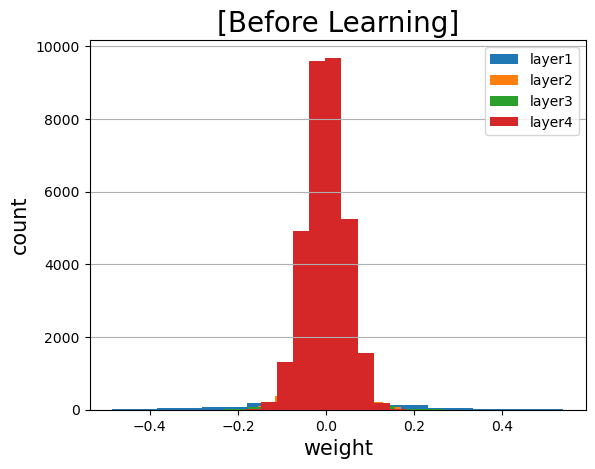

In [19]:
for name, child in my_model.named_children():
    for param in child.parameters():
        plt.hist(param.detach().numpy().flatten(), label = name)
        plt.xlabel('weight', size = 15)
        plt.ylabel('count', size = 15)
        break
plt.title('[Before Learning]', size = 20)
plt.grid(axis = 'y')
plt.legend()
plt.show()

In [20]:
# 학습 준비
OPTIMIZER = optim.Adam(params = my_model.parameters())
criterion = nn.CrossEntropyLoss()  # 손실 함수 정의
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 5)
CLASSES = 23
EPOCHS = 30

In [21]:
### ===> CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    train_loss_list = []
    train_acc_list = []
    #train_correct_list = []
    train_f1score_list = []
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        # print(output.argmax(dim = 1), label)
        # print(output.argmax(dim = 1) == label)
        loss = criterion(output, label)
        train_loss_list.append(loss.item())
        #prediction = output.max(1, keepdim = True)[1]
        #correct = prediction.eq(label.view_as(prediction)).sum().item()
        #train_correct_list.append(correct)
        train_accuracy = metrics.accuracy(output, label, task = 'multiclass', num_classes = CLASSES).item()
        train_acc_list.append(train_accuracy)
        train_f1_score = metrics.f1_score(output, label, task = 'multiclass', num_classes = CLASSES).item()
        train_f1score_list.append(train_f1_score)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}")
    
    train_loss = sum(train_loss_list) / len(train_loader)
    #train_loss = np.mean(train_loss_list)
    train_accuracy = sum(train_acc_list) / len(train_loader)
    #train_accuracy = metrics.accuracy(output, label, task = 'multiclass', num_classes = CLASSES)
    #train_f1_score = sum(train_f1score_list) / len(train_loader.dataset)
    train_f1_score = sum(train_f1score_list) / len(train_loader)
    return train_loss, train_accuracy, train_f1_score   

In [22]:
### ===> 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, val_loader):
    model.eval()
    #test_loss = 0
    #correct = 0
    #test_f1_score = 0
    val_loss_list = []
    val_acc_list = []
    val_f1score_list = []
    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            val_loss = criterion(output, label).item()
            val_loss_list.append(val_loss)
            #test_loss += criterion(output, label).item()
            #prediction = output.max(1, keepdim = True)[1]
            #correct += prediction.eq(label.view_as(prediction)).sum().item()
            val_accuracy = metrics.accuracy(output, label, task = 'multiclass', num_classes = CLASSES).item()
            val_acc_list.append(val_accuracy)
            val_f1_score = metrics.f1_score(output, label, task = 'multiclass', num_classes = CLASSES).item()
            val_f1score_list.append(val_f1_score)
            #test_f1_score += metrics.f1_score(output, label, task='multiclass', num_classes = CLASSES).item()
            #test_list.append(metrics.accuracy(output, label, task='multiclass', num_classes = CLASSES))
          
    val_loss = sum(val_loss_list) / len(val_loader)
    val_accuracy = sum(val_acc_list) / len(val_loader)
    #test_accuracy = np.mean(test_list)
    val_f1_score = sum(val_f1score_list) / len(val_loader)
    return val_loss, val_accuracy, val_f1_score

In [23]:
loss_list = [[], []]
acc_list = [[], []]
f1_list = [[], []]
for epoch in range(1, EPOCHS + 1):
    
    train_loss, train_accuracy, train_f1_score = train(epoch, my_model, trainDL, OPTIMIZER, log_interval = 200)
    val_loss, val_accuracy, val_f1_score = evaluate(my_model, validDL)
    
    print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tTrain F1 score : {train_f1_score}\n")
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {val_loss:.4f}, \tTest Accuracy: {val_accuracy:.2f} % \tTest F1 score :{val_f1_score}\n")

    SCHEDULER.step(val_loss)
    # 조기종료 기능 => 조건 : test_loss가 지정된 횟수이상 개선이 안되면 학습 종료
    if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
        print(f'Early stopping at epoch {epoch}')
        break

    loss_list[0].append(train_loss)
    loss_list[1].append(val_loss)
    acc_list[0].append(train_accuracy)
    acc_list[1].append(val_accuracy)
    f1_list[0].append(train_f1_score)
    f1_list[1].append(val_f1_score)

Train Epoch: 1 [0]	Train Loss: 3.793408
Train Epoch: 1 [200]	Train Loss: 3.026367

[EPOCH: 1], 	Train Loss: 3.1573, 	Train Accuracy: 0.10 %, 	Train F1 score : 0.09908353365384616


[EPOCH: 1], 	Test Loss: 3.0722, 	Test Accuracy: 0.07 % 	Test F1 score :0.07320926966292135

Train Epoch: 2 [0]	Train Loss: 2.957217
Train Epoch: 2 [200]	Train Loss: 2.923967

[EPOCH: 2], 	Train Loss: 2.8588, 	Train Accuracy: 0.17 %, 	Train F1 score : 0.17232572115384615


[EPOCH: 2], 	Test Loss: 3.0443, 	Test Accuracy: 0.10 % 	Test F1 score :0.09726123595505617

Train Epoch: 3 [0]	Train Loss: 2.691261
Train Epoch: 3 [200]	Train Loss: 2.551682

[EPOCH: 3], 	Train Loss: 2.7505, 	Train Accuracy: 0.20 %, 	Train F1 score : 0.19846754807692307


[EPOCH: 3], 	Test Loss: 3.0451, 	Test Accuracy: 0.12 % 	Test F1 score :0.12482443820224719

Train Epoch: 4 [0]	Train Loss: 2.613139
Train Epoch: 4 [200]	Train Loss: 2.641350

[EPOCH: 4], 	Train Loss: 2.6845, 	Train Accuracy: 0.21 %, 	Train F1 score : 0.21221454326923078




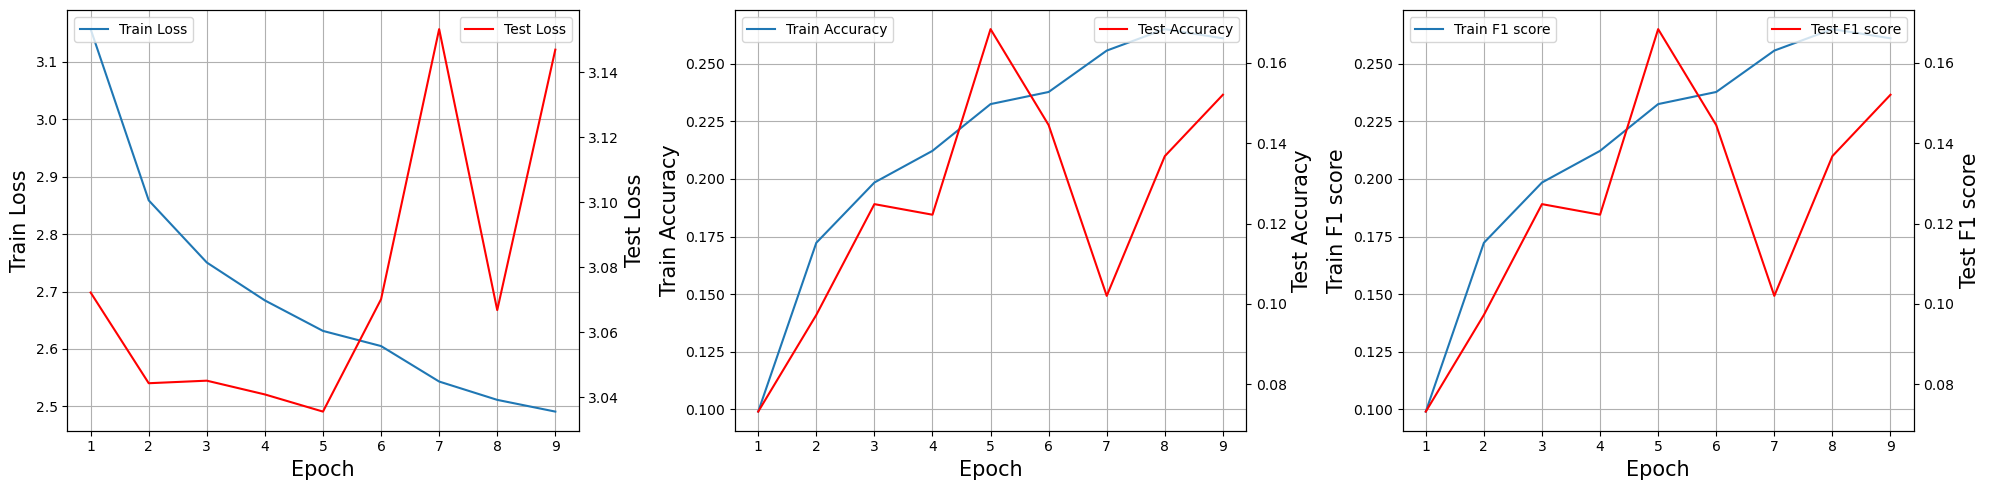

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(loss_list[0], label = "Train Loss")
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Epoch", size = 15)
axes[0].set_ylabel("Train Loss", size = 15)
axes[0].set_xticks(np.arange(EPOCHS))
axes[0].set_xticklabels(np.arange(1, EPOCHS + 1))
axes[0].grid()
axes2 = axes[0].twinx()
axes2.plot(loss_list[1], label = "Test Loss", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Test Loss", size = 15)

axes[1].plot(acc_list[0], label = "Train Accuracy")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Epoch", size = 15)
axes[1].set_ylabel("Train Accuracy", size = 15)
axes[1].set_xticks(np.arange(EPOCHS))
axes[1].set_xticklabels(np.arange(1, EPOCHS + 1))
axes[1].grid()
axes2 = axes[1].twinx()
axes2.plot(acc_list[1], label = "Test Accuracy", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Test Accuracy", size = 15)

axes[2].plot(f1_list[0], label = "Train F1 score")
axes[2].legend(loc="upper left")
axes[2].set_xlabel("Epoch", size = 15)
axes[2].set_ylabel("Train F1 score", size = 15)
axes[2].set_xticks(np.arange(EPOCHS))
axes[2].set_xticklabels(np.arange(1, EPOCHS + 1))
axes[2].grid()
axes2 = axes[2].twinx()
axes2.plot(f1_list[1], label = "Test F1 score", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Test F1 score", size = 15)
plt.tight_layout()
plt.show()

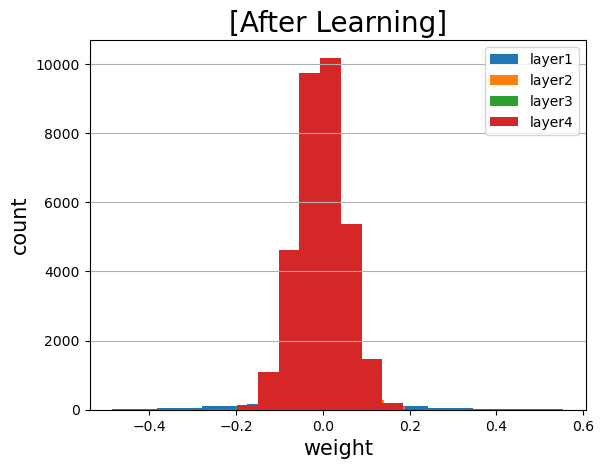

In [25]:
for name, child in my_model.named_children():
    for param in child.parameters():
        plt.hist(param.detach().numpy().flatten(), label = name)
        plt.xlabel('weight', size = 15)
        plt.ylabel('count', size = 15)
        break
plt.legend()
plt.grid(axis = 'y')
plt.title('[After Learning]', size = 20)
plt.show()

In [26]:
type(list(my_model.named_children())[1][1][0])

torch.nn.modules.conv.Conv2d

In [27]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(my_model.named_children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i][1][0]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i][1][0].weight)
        conv_layers.append(model_children[i][1][0])
    elif type(model_children[i][1][0]) == nn.Sequential:
        for j in range(len(model_children[i][1][0])):
            for child in model_children[i][1][0][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 3
conv_layers


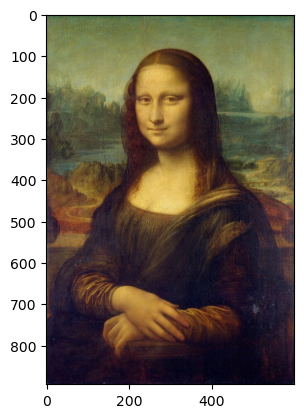

In [28]:
image = Image.open('./DATA/davinci.jpg')
plt.imshow(image)
plt.show()

In [29]:
preprocessing2 = transforms.Compose([transforms.Resize(size = (64, 64)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])

In [30]:
image = preprocessing2(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(DEVICE)

Image shape before: torch.Size([3, 64, 64])
Image shape after: torch.Size([1, 3, 64, 64])


In [31]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

3
torch.Size([1, 32, 64, 64])
torch.Size([1, 16, 64, 64])
torch.Size([1, 8, 64, 64])


In [32]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(64, 64)
(64, 64)
(64, 64)


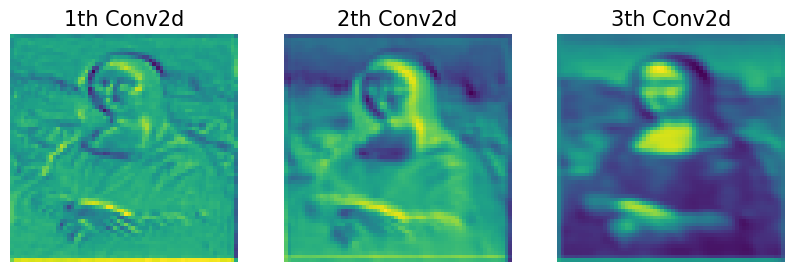

In [33]:
fig = plt.figure(figsize=(10, 10))
for i in range(len(processed)):
    a = fig.add_subplot(1, 3, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(f"{i+1}th {names[i].split('(')[0]}", fontsize = 15)

In [34]:
# 예측 함수
def predict(data):
    
    my_model.eval()
    
    with torch.no_grad():
        output = my_model(data)
    
    prediction = output.max(1, keepdim = True)[1]
        
    return prediction

In [35]:
def pred_show(path = './DATA/Pablo Picasso.jpeg'):
    data = Image.open(path)
    data = preprocessing2(data)
    data = data.unsqueeze(0)
    prediction = predict(data)
    df = train_infoDF[train_infoDF['class'] == prediction.item()]
    print(f"모델이 예측한 화가는 {df['file name'].str.split('_').iloc[0][0]}입니다.\n")
    print(f"다음 그림의 화가는 {path[7:-5]}입니다.")
    image = Image.open(path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

모델이 예측한 화가는 pyotr-konchalovsky입니다.

다음 그림의 화가는 Pablo Picasso입니다.


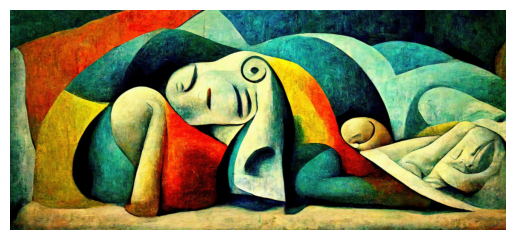

In [36]:
pred_show()